Finding Dominant Color Names from Color Space Coordinates and Images
=========================================

![](jupysmug.png)

## Let's install some software.

This notebook will explore various techniques for analyzing the contents of digital images
and computing:

1.  Color names from RGB, HSL and LAB color space coordinates.

2.  Finding a color "nearest" a preset pallette of colors.

3.  Computing an image's dominant color and returning a "nearest" color name.

To do this it may be necessary to install a number of packages. 
The following install commands will gather required packages.

In [8]:
!cd \anaconda3
!python -m pip install webcolors

In [19]:
!cd \anaconda3
!python -m pip install Pillow

## Using `webcolors` to Reverse Color Code.

After installing `webcolors` test it with this code snippet from [Stack Overflow](https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python).

In [44]:
import webcolors

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.css3_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

requested_colour = (119, 172, 152)
actual_name, closest_name = get_colour_name(requested_colour)

print("Actual colour name:", actual_name, ", closest colour name:", closest_name)

Actual colour name: None , closest colour name: cadetblue


In [45]:
rgb0 = (0,0,0)
rgb1 = (255,255,255)
rgb2 = (255,0,0)
rgb3 = (0,255,0)
rgb4 = (0,0,255)

print(get_colour_name(rgb0))
print(get_colour_name(rgb1))
print(get_colour_name(rgb2))
print(get_colour_name(rgb3))
print(get_colour_name(rgb4))

('black', 'black')
('white', 'white')
('red', 'red')
('lime', 'lime')
('blue', 'blue')


## Generate Some Random Colors

In [46]:
from random import randint
print(randint(0, 255))

29


In [47]:
for a,b in 25 * [(0,255)]:
    rgb = (randint(a,b), randint(a,b), randint(a,b))
    print(get_colour_name(rgb)[-1])

slateblue
silver
wheat
mediumpurple
mediumseagreen
lightpink
black
forestgreen
palegoldenrod
limegreen
purple
yellow
lightseagreen
darkslateblue
lightgreen
firebrick
slateblue
mediumaquamarine
royalblue
dimgrey
sienna
darkolivegreen
palegreen
seagreen
royalblue


## First Dominant Color Calculation

After installing Pillow and making some minor code edits it's possible to 
run this [algorithm from Stack Overflow](https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image).

In [14]:
import struct
from PIL import Image
import numpy as np
import scipy
import scipy.misc
import scipy.cluster

In [40]:
NUM_CLUSTERS = 5

print('reading image')
im = Image.open('C:/SmugMirror/Themes/Manipulations/ImageHacking/5NB7dXP-1f-green-gray-dragon-eggs.jpg')
im = im.resize((300, 300))      # optional, to reduce time
ar = np.asarray(im)
shape = ar.shape
ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)

print('finding clusters')
codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
print ('cluster centres:\n', codes)

vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences

index_max = scipy.argmax(counts)                    # find most frequent
peak = codes[index_max]
print('peak', peak)
#colour = ''.join(chr(int(c)) for c in peak).encode('hex')
colour = ''.join(chr(int(c)) for c in peak) 
print('most frequent is %s (#%s)' % (peak, colour))

reading image
finding clusters
cluster centres:
 [[  94.20777643  154.62643445   14.78878088]
 [  19.25977821   26.51046879   10.5614316 ]
 [ 187.73955995  208.61131567  164.737674  ]
 [  60.24862032   83.22052511   31.39857294]
 [ 133.44153693  161.31121942   92.10921308]]
peak [ 19.25977821  26.51046879  10.5614316 ]
most frequent is [ 19.25977821  26.51046879  10.5614316 ] (#
)


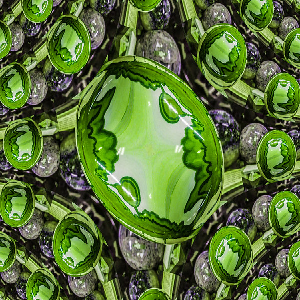

In [41]:
display(im)

In [48]:
print(im)

<PIL.Image.Image image mode=RGB size=300x300 at 0x86E8007C88>


## Second Dominant Color Calculation

This algorithm, due to [Charlies Leifer](https://charlesleifer.com/blog/using-python-and-k-means-to-find-the-dominant-colors-in-images/), also computes dominant colors.

In [49]:
from collections import namedtuple
from math import sqrt
import random
from PIL import Image
    
#try:
#    import Image
#except ImportError:
#    from PIL import Image

Point = namedtuple('Point', ('coords', 'n', 'ct'))
Cluster = namedtuple('Cluster', ('points', 'center', 'n'))

def get_points(img):
    points = []
    w, h = img.size
    for count, color in img.getcolors(w * h):
        points.append(Point(color, 3, count))
    return points

rtoh = lambda rgb: '#%s' % ''.join(('%02x' % p for p in rgb))

def colorz(filename, n=3):
    img = Image.open(filename)
    img.thumbnail((200, 200))
    w, h = img.size

    points = get_points(img)
    clusters = kmeans(points, n, 1)
    rgbs = [map(int, c.center.coords) for c in clusters]
    return map(rtoh, rgbs)

def euclidean(p1, p2):
    return sqrt(sum([
        (p1.coords[i] - p2.coords[i]) ** 2 for i in range(p1.n)
    ]))

def calculate_center(points, n):
    vals = [0.0 for i in range(n)]
    plen = 0
    for p in points:
        plen += p.ct
        for i in range(n):
            vals[i] += (p.coords[i] * p.ct)
    return Point([(v / plen) for v in vals], n, 1)

def kmeans(points, k, min_diff):
    clusters = [Cluster([p], p, p.n) for p in random.sample(points, k)]

    while 1:
        plists = [[] for i in range(k)]

        for p in points:
            smallest_distance = float('Inf')
            for i in range(k):
                distance = euclidean(p, clusters[i].center)
                if distance < smallest_distance:
                    smallest_distance = distance
                    idx = i
            plists[idx].append(p)

        diff = 0
        for i in range(k):
            old = clusters[i]
            center = calculate_center(plists[i], old.n)
            new = Cluster(plists[i], center, old.n)
            clusters[i] = new
            diff = max(diff, euclidean(old.center, new.center))

        if diff < min_diff:
            break

    return clusters

In [69]:
dmap = colorz('C:/SmugMirror/Themes/Manipulations/ImageHacking/5NB7dXP-1f-green-gray-dragon-eggs.jpg')

In [70]:
list(dmap)

['#212d11', '#5e862a', '#9cb77b']

In [71]:
rgb = webcolors.hex_to_rgb('#5f872a')
get_colour_name(rgb)

(None, 'olivedrab')

In [77]:
# "nearest" named dominant colors
dmap = colorz('C:/SmugMirror/Themes/Manipulations/ImageHacking/5NB7dXP-1f-green-gray-dragon-eggs.jpg')
for hxc in list(dmap):
    rgb = webcolors.hex_to_rgb(hxc)
    print(get_colour_name(rgb)[-1])  

olivedrab
black
darkseagreen


In [78]:
im2 = Image.open('C:/SmugMirror/Themes/Manipulations/ImageHacking/hjbftwN-1-your-grainy-hell-awaits-[409595101].jpg')

In [79]:
print(im2.size)

(300, 450)


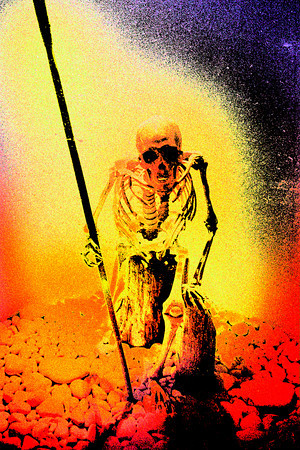

In [80]:
display(im2)

In [82]:
# "nearest" named dominant colors
dmap = colorz('C:/SmugMirror/Themes/Manipulations/ImageHacking/hjbftwN-1-your-grainy-hell-awaits-[409595101].jpg')
for hxc in list(dmap):
    rgb = webcolors.hex_to_rgb(hxc)
    print(get_colour_name(rgb)[-1])  

chocolate
khaki
black
